# Clustering and Principal Component Analysis (PCA)

In [2]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import time

from sklearn import cluster, datasets
from sklearn.cluster  import KMeans
from sklearn.datasets import load_digits          # MNIST data
from sklearn.neighbors import kneighbors_graph    # If you do anything hierarchical
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import cdist

from IPython.display  import Image as display_image

%matplotlib inline  

### PART1: Clustering as Image Segmentation

(314, 500, 4)


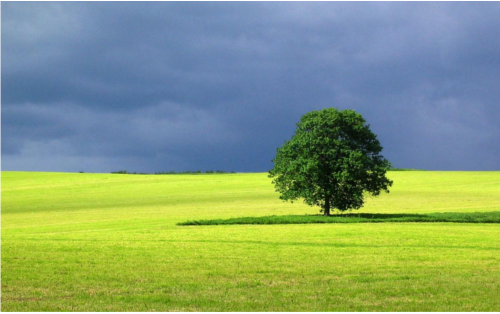

In [3]:
# Read an image from a file as an array
img = sp.misc.imread('./Landscape_small.png')
print (img.shape)
display_image(filename='./Landscape_small.png')

### The image consists of 314 x 500 pixels. (Hence the 314 x 500 array). Each entry encodes the colour/pixel - 4 values, one for each of the primary (rgb) colours as well as an alpha (opacity) value. 

In [4]:
# Remove the opacity as we don't need it
img = img[:, :, :3]

# Flatten the 2D array into a 1D array. 
img_flat = sp.reshape(img, (img.shape[0]*img.shape[1],3)).astype(float)

print(img_flat.shape)

(157000, 3)


### K-means - memorise the sklearn syntax (essentially the same as always)

In [5]:
# K-means 'classifier'. Note how we have to specify the number of clusters

clf = KMeans(n_clusters = 10, init='k-means++')
clf.fit(img_flat.astype(float))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [6]:
# Calculated centroids above. Now assign cluster membership to each point in the data

indices= clf.predict(img_flat)

### Reshape again (to display the image via plt.imshow)

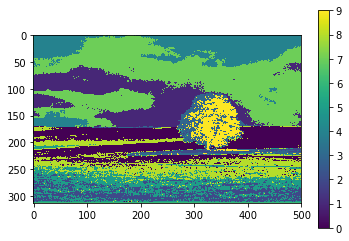

In [8]:
plt.imshow(sp.reshape(indices, (img.shape[0], img.shape[1])))
plt.colorbar()
plt.show()

### How should we choose the optimal number of clusters ?

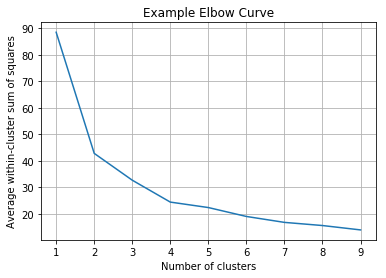

In [9]:
centroids=[[] for i in range(1,10)]
euclidean_distances=[0 for i in range(len(img_flat))]
cluster_averaged_distances=[0 for i in range(1,10)]

for K in range(1,10):
    clf = KMeans(n_clusters = K, init='k-means++')
    clf.fit(img_flat.astype(float))
    indices= clf.predict(img_flat)
    
    centroids= clf.cluster_centers_ 
    
    for j in range(len(img_flat)):
        euclidean_distances[j]=0
        cluster=indices[j]
        for k in range(3):
            euclidean_distances[j]+=(img_flat[j][k] - centroids[cluster][k])**2
        euclidean_distances[j]=(euclidean_distances[j])**0.5

    cluster_averaged_distances[K-1]=np.mean(euclidean_distances)
               
plt.plot(range(1,10),cluster_averaged_distances)
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Example Elbow Curve')  

### It's worth noting elbow curves are idealised....I don't think I've ever seen one in the wild...

### The loops in the calculation above make it slow. Scipy has a faster vectorised black-box implementation.

In [22]:
clf_nl = [kmeans(img_flat,k) for k in range(1,10)]
# from scipy.cluster.vq

In [25]:
distances = [clf_nl[i][1] for i in range(len(clf_nl))]

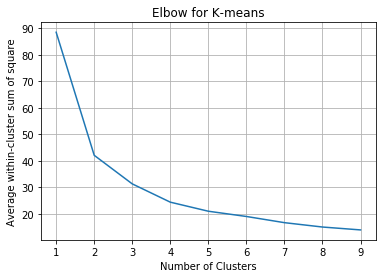

In [26]:
plt.plot(range(1,10),distances)
plt.grid(True)
plt.xlabel('Number of Clusters')
plt.ylabel('Average within-cluster sum of square')
plt.title('Elbow for K-means')
plt.show()

In [ ]:
# K = range(1,10)

# IMPORTANT! Note the different call below to kmeans. This is scipy and not sklearn

# KM = [kmeans(img_flat,k) for k in K] 

# The scipy method holds the results in a somewhat different format. It stores the coordinates of 
# all centroids together with the average distance of points from their closest centroid (which is what we're after)

# distances=[KM[i][1] for i in range(len(KM))]

# plt.plot(range(1,10),distances)
# plt.grid(True)
# plt.xlabel('Number of clusters')
# plt.ylabel('Average within-cluster sum of squares')
# tt = plt.title('Elbow for K-Means clustering') 


### TASK: So what's the optimal number of clusters here? Re-run kmeans with these parameters

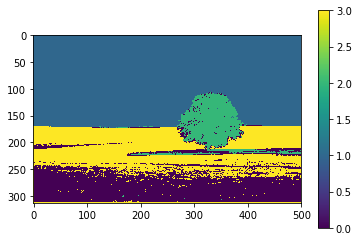

In [29]:
k = 4
clf_op = KMeans(k, init='k-means++')
clf_op.fit(img_flat.astype(float))
indices_op = clf_op.predict(img_flat)
plt.imshow(sp.reshape(indices_op, (img.shape[0], img.shape[1])))
plt.colorbar()
plt.show()

### OPTIONAL TASK: Repeat the image segmentation above with your favourite .png on instagram. This often produces hilarious results

### PART2: Digits Data and PCA

In [32]:
digits = load_digits()
digits.data.shape

X_scaled = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

print (digits.data.shape,X_scaled.shape, y.shape)

(1797, 64) (1797, 64) (1797,)


In [42]:
X_scaled[0]

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

In [38]:
import seaborn as sns # Import this separately as it seems make the above images black and white (Ipython display)

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])

    return f, ax, sc

### This is the sklearn implementation of PCA. Simply state number of components you wish to retain

(<matplotlib.figure.Figure at 0x7ff5b6d09c50>,
 <matplotlib.collections.PathCollection at 0x7ff5b58e9940>)

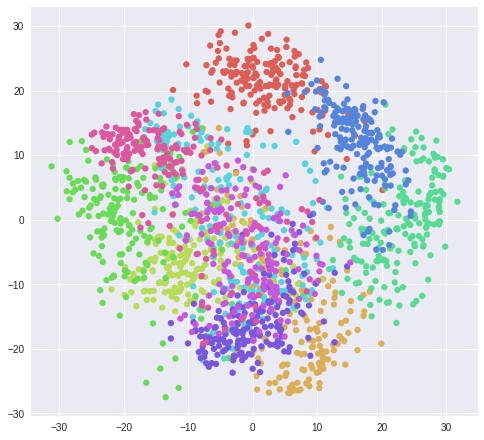

In [50]:
pca = PCA(n_components=30)                           
X_pca = pca.fit_transform(X_scaled)
scatter(X_pca, y)

In [49]:
PCA?

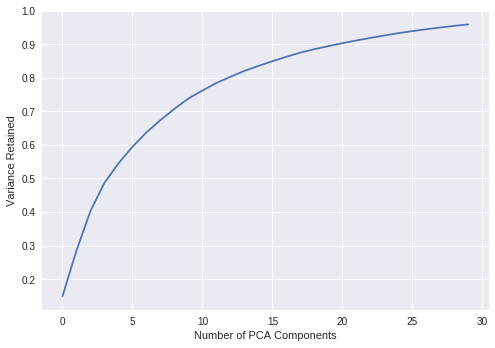

In [51]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.ylabel('Variance Retained')
plt.xlabel('Number of PCA Components')

In [52]:
pca.explained_variance_ratio_.cumsum()

array([ 0.14890594,  0.28509365,  0.40303959,  0.48713938,  0.54496353,
        0.59413263,  0.6372925 ,  0.67390623,  0.70743871,  0.73822677,
        0.76195018,  0.78467714,  0.80289578,  0.82063433,  0.83530534,
        0.84940249,  0.86258838,  0.87506976,  0.88524694,  0.89430311,
        0.90319849,  0.9111697 ,  0.91884461,  0.92607362,  0.93303241,
        0.93899287,  0.94474894,  0.94989974,  0.95479274,  0.95908134])

### TASK: How many principal components should we retain for the MNIST data? You've got the luxury of labels here. Cluster the PCA'd dataset and compare the true labels to what you get from clustering. Can clustering alone identify the digits here?

In [54]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [55]:
pca_op = PCA(n_components=28)                           
X_pca_op = pca_op.fit_transform(X_scaled)
Clf_pca = KMeans(len(np.unique(y)),init = 'k-means++')
Clf_pca.fit(X_pca_op)
indices_pca_op = Clf_pca.predict(X_pca_op)

In [59]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y,indices_pca_op)

0.66508898261475047

### TASK: There are other dimensional reduction algorithms that can perform better e.g. t-SNE. Repeat the task above but now for t-SNE (syntax below). Look at that crazy cluster separation!

In [62]:
from sklearn.manifold import TSNE
X_tsne = TSNE(random_state = 42).fit_transform(X_scaled)

(<matplotlib.figure.Figure at 0x7ff5b5823828>,
 <matplotlib.collections.PathCollection at 0x7ff5b6907f98>)

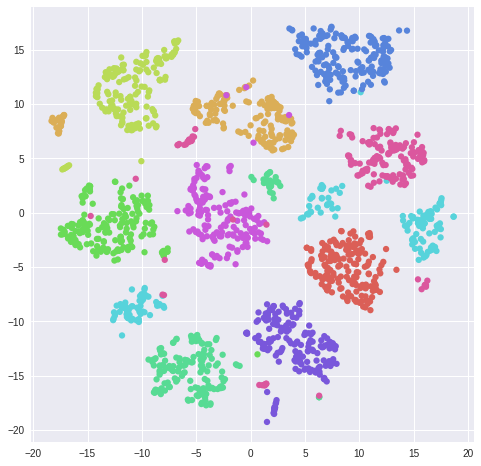

In [63]:
scatter(X_tsne, y)

In [65]:
Clf_tsne = KMeans(len(np.unique(y)),init = 'k-means++')
Clf_tsne.fit(X_tsne)
indices_tsne = Clf_tsne.predict(X_tsne)
adjusted_rand_score(y,indices_tsne)

0.77482050894796872

### PART3: Other Clustering Algorithms

In [66]:
del(cluster) # Clear this variable from memory (alternatively sledgehammer approach - restart kernel...)

In [67]:
# Generate four standard datasets for clustering. No need to worry about this block of code.

n_samples = 1500

noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None
colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

In [68]:
# A (messy) plotting function lovingly made just for you. Can safely ignore the details. Just call it below.

# Arguments: Names of algorithms you use and the Classifiers you use

def PlotClustering(clustering_names, clustering_algorithms):
    
    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))

    plot_num = 1

    datasets = [noisy_circles, noisy_moons, blobs, no_structure]
    for i_dataset, dataset in enumerate(datasets):
        X, y = dataset
        X = StandardScaler().fit_transform(X) # NOTE THIS IMPORTANT STEP HERE

        for name, algorithm in zip(clustering_names, clustering_algorithms):
            # Predict cluster memberships
            plt.subplot(4, len(clustering_algorithms), plot_num)
            if i_dataset == 0:
                plt.title(name, size=18)

            if algorithm is None:
                plt.scatter(X[:, 0], X[:, 1], color='gray', s=10)
            else:
                t0 = time.time()
                algorithm.fit(X)
                t1 = time.time()
                if hasattr(algorithm, 'labels_'):
                    y_pred = algorithm.labels_.astype(np.int)
                else:
                    y_pred = algorithm.predict(X)

                # Plot
                plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

                if hasattr(algorithm, 'cluster_centers_'):
                    centers = algorithm.cluster_centers_
                    center_colors = colors[:len(centers)]
                    plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            plt.xlim(-2, 2)
            plt.ylim(-2, 2)
            plt.xticks(())
            plt.yticks(())
            if algorithm is not None:
                plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                         transform=plt.gca().transAxes, size=15,
                         horizontalalignment='right')
            plot_num += 1

    plt.show()    
    

### TASK:  Discover what algorithms are best able to resolve the four datasets below into clusters?

In [97]:
cluster.AgglomerativeClustering?

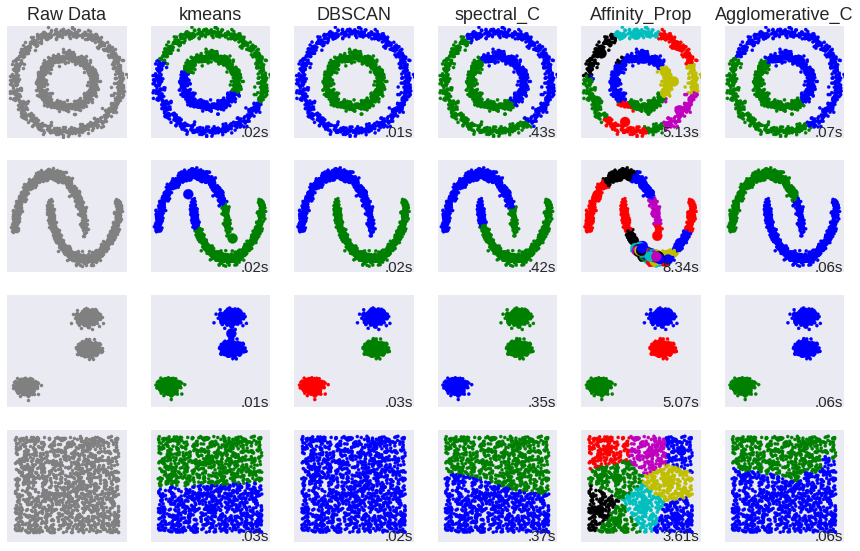

In [99]:
###### YOUR CODE GOES HERE ########
###################################

# RUN SOME CLUSTERING ALGORITHMS THAT BEST SEPARATE THIS DATA.
# You can see from what I've shown below that kmeans doesn't work that well here.

# QUESTION FOR YOU: WHY? 

###################################
###################################

from sklearn import cluster

kmeans = cluster.KMeans(n_clusters = 2)
dbscan = cluster.DBSCAN(eps = 0.3)
spectral = cluster.SpectralClustering(n_clusters = 2)
aff_prop = cluster.AffinityPropagation(0.7,preference = -50)
#agg = cluster.AgglomerativeClustering(n_clusters = 2)
#mnbkmeans = cluster.MiniBatchKMeans(n_clusters=2)


names = ['Raw Data', 'kmeans','DBSCAN','spectral_C','Affinity_Prop','Agglomerative_C']
algorithms = [None, kmeans,dbscan,spectral,aff_prop,agg] 

PlotClustering(names, algorithms)